In [1]:
import re
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score


In [2]:
# Membaca data dari file CSV
df = pd.read_csv('Data_Train.csv')

# Menampilkan data sampel
print(df)


                                              full_text      username  MBTI  \
0     masih about my wedding makeup kali ini makeup ...   DylanSahara  ENFJ   
1     terima kasih kepada bapak prabowo subianto yan...   DylanSahara  ENFJ   
2                             halo calon suami hahahaha   DylanSahara  ENFJ   
3     muka dicoretcoret pakai kostum kayak orang gil...   DylanSahara  ENFJ   
4          saat muka masih cakep belum dicemongcemongin   DylanSahara  ENFJ   
...                                                 ...           ...   ...   
9345  itu adalah tuntutan peran dan sebagai pelaku a...  chelseaislan  ESFJ   
9346  aku harus total dalam setiap peran film yang a...  chelseaislan  ESFJ   
9347  dukung naura di mom amp kid awards sebagai pen...  chelseaislan  ESFJ   
9348  terima kasih tuhan untuk semua kisah hidupku a...  chelseaislan  ESFJ   
9349  rt movie berkat doadukungan kalian film kami m...  chelseaislan  ESFJ   

     IE NS TF JP  
0     E  N  F  J  
1     E  N  F

In [3]:
# 2. Preprocessing ringan (Case folding + cleaning sederhana)
def clean_text(text):
    text = text.lower()  # case folding
    text = re.sub(r'http\S+', '', text)  # hapus URL
    text = re.sub(r'[^a-z\s]', '', text)  # hapus simbol non-huruf
    text = re.sub(r'\s+', ' ', text).strip()  # normalisasi spasi
    return text

df['clean_text'] = df['full_text'].astype(str).apply(clean_text)

In [4]:
# 1. TF-IDF Vectorization dengan 1000 fitur kata teratas
vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = vectorizer.fit_transform(df['clean_text']).toarray()

# 2. Tentukan threshold per fitur (kolom) berdasarkan median nilai TF-IDF
threshold = np.median(X_tfidf, axis=0)  # median per kolom fitur

# 3. Ubah nilai TF-IDF menjadi binary (0 atau 1) berdasarkan threshold
X_binary = (X_tfidf > threshold).astype(int)

# 4. Ambil label MBTI per dimensi (pastikan kolom sudah benar)
y_IE = df['IE'].values
y_NS = df['NS'].values
y_TF = df['TF'].values
y_JP = df['JP'].values

# 5. (Opsional) Ubah hasil biner TF-IDF jadi DataFrame untuk cek
tfidf_binary_df = pd.DataFrame(X_binary, columns=vectorizer.get_feature_names_out())
print(tfidf_binary_df.head())


   aamiin  abang  acara  ada  adalah  adam  adik  admin  aduh  agak  ...  yah  \
0       0      0      0    0       0     0     0      0     0     0  ...    0   
1       0      0      0    0       0     0     0      0     0     0  ...    0   
2       0      0      0    0       0     0     0      0     0     0  ...    0   
3       0      0      0    0       0     0     0      0     0     0  ...    0   
4       0      0      0    0       0     0     0      0     0     0  ...    0   

   yaitu  yak  yakin  yang  yogyakarta  you  youtube  yuk  zon  
0      0    0      0     0           0    0        0    0    0  
1      0    0      0     1           0    0        0    0    0  
2      0    0      0     0           0    0        0    0    0  
3      0    0      0     0           0    0        0    0    0  
4      0    0      0     0           0    0        0    0    0  

[5 rows x 1000 columns]


In [5]:
# Pertama bagi index data untuk train dan val sekali saja,
# supaya X dan semua y dimensi sama proporsi dan indeksnya sinkron
train_idx, val_idx = train_test_split(
    range(len(X_tfidf)),
    test_size=0.2,
    random_state=42,
    stratify=y_IE  # stratify berdasarkan label utama (bisa y_IE atau lainnya)
)

# Pilah data berdasarkan index ini
X_train = X_tfidf[train_idx]
X_val = X_tfidf[val_idx]

y_train_IE = y_IE[train_idx]
y_val_IE = y_IE[val_idx]

y_train_NS = y_NS[train_idx]
y_val_NS = y_NS[val_idx]

y_train_TF = y_TF[train_idx]
y_val_TF = y_TF[val_idx]

y_train_JP = y_JP[train_idx]
y_val_JP = y_JP[val_idx]

# Sekarang datanya sudah terpisah konsisten
labels = {
    'IE': (y_train_IE, y_val_IE),
    'NS': (y_train_NS, y_val_NS),
    'TF': (y_train_TF, y_val_TF),
    'JP': (y_train_JP, y_val_JP),
}

print(f"Jumlah data training   : {X_train.shape[0]}")
print(f"Jumlah data validasi   : {X_val.shape[0]}")

print(f"Distribusi y_train_IE  : {pd.Series(y_train_IE).value_counts().to_dict()}")
print(f"Distribusi y_val_IE    : {pd.Series(y_val_IE).value_counts().to_dict()}")

print(f"Distribusi y_train_NS  : {pd.Series(y_train_NS).value_counts().to_dict()}")
print(f"Distribusi y_val_NS    : {pd.Series(y_val_NS).value_counts().to_dict()}")

print(f"Distribusi y_train_TF  : {pd.Series(y_train_TF).value_counts().to_dict()}")
print(f"Distribusi y_val_TF    : {pd.Series(y_val_TF).value_counts().to_dict()}")

print(f"Distribusi y_train_JP  : {pd.Series(y_train_JP).value_counts().to_dict()}")
print(f"Distribusi y_val_JP    : {pd.Series(y_val_JP).value_counts().to_dict()}")


Jumlah data training   : 7480
Jumlah data validasi   : 1870
Distribusi y_train_IE  : {'E': 4840, 'I': 2640}
Distribusi y_val_IE    : {'E': 1210, 'I': 660}
Distribusi y_train_NS  : {'N': 3979, 'S': 3501}
Distribusi y_val_NS    : {'N': 971, 'S': 899}
Distribusi y_train_TF  : {'F': 4765, 'T': 2715}
Distribusi y_val_TF    : {'F': 1235, 'T': 635}
Distribusi y_train_JP  : {'P': 4158, 'J': 3322}
Distribusi y_val_JP    : {'P': 1042, 'J': 828}


In [6]:
# Parameter GA
POP_SIZE = 10                    # Jumlah individu dalam 1 populasi
CHROMOSOME_LENGTH = X_tfidf.shape[1]  # = 1000 fitur TF-IDF
P_INITIALIZE = 0.9              # Probabilitas inisialisasi gen aktif
P_CROSSOVER = 0.9               # Probabilitas crossover
MUTATION_RATE = 0.1             # Probabilitas mutasi per gen
N_GENERATIONS = 50             # Jumlah generasi maksimum
C_RANGE = (0.1, 100)            # Rentang nilai C untuk SVM

In [7]:
def initialize_population():
    population = np.random.randint(2, size=(POP_SIZE, CHROMOSOME_LENGTH))  # fitur binary
    new_population = []
    for i in range(POP_SIZE):
        C_value = np.random.uniform(C_RANGE[0], C_RANGE[1])  # nilai C float
        # Gabungkan fitur dan nilai C menjadi kromosom panjang CHROMOSOME_LENGTH + 1
        individual = np.append(population[i], C_value)
        new_population.append(individual)
    return np.array(new_population)

In [8]:
# 3. Inisialisasi populasi
population = initialize_population()
# Inisialisasi history
best_fitness_history = []
best_chromosome_history = []

In [9]:
# Fungsi untuk menghitung fitness
def fitness_score(chromosome, X_train, y_train, X_val, y_val):
    selected = [i for i, bit in enumerate(chromosome[:-1]) if bit == 1]
    if len(selected) == 0:
        return 0

    # Pastikan nilai C tidak terlalu kecil
    C_value = max(0.01, chromosome[-1])

    # Gunakan SVM dengan kernel RBF
    clf = SVC(C=C_value, kernel='rbf', gamma='scale')
    clf.fit(X_train[:, selected], y_train)
    y_pred = clf.predict(X_val[:, selected])

    return accuracy_score(y_val, y_pred)


In [10]:
# 4. Evaluasi fitness awal
scores_all = {label: [] for label in labels}
print("=== Evaluasi Fitness Awal ===")
for label_name, (y_train_label, y_val_label) in labels.items():
    print(f"\nLabel: {label_name}")
    for i, chromosome in enumerate(population):
        fitness_value = fitness_score(chromosome, X_train, y_train_label, X_val, y_val_label)
        scores_all[label_name].append(fitness_value)
        print(f"Individu {i+1}: C = {chromosome[-1]:.4f}, Fitness = {fitness_value:.4f}")

=== Evaluasi Fitness Awal ===

Label: IE
Individu 1: C = 69.6138, Fitness = 0.6342
Individu 2: C = 5.1454, Fitness = 0.6497
Individu 3: C = 65.4941, Fitness = 0.6155
Individu 4: C = 86.3678, Fitness = 0.6187
Individu 5: C = 64.8147, Fitness = 0.6193
Individu 6: C = 61.0344, Fitness = 0.5995
Individu 7: C = 85.1077, Fitness = 0.6059
Individu 8: C = 33.4248, Fitness = 0.6134
Individu 9: C = 7.9134, Fitness = 0.6305
Individu 10: C = 71.2285, Fitness = 0.6299

Label: NS
Individu 1: C = 69.6138, Fitness = 0.5674
Individu 2: C = 5.1454, Fitness = 0.5786
Individu 3: C = 65.4941, Fitness = 0.5545
Individu 4: C = 86.3678, Fitness = 0.5770
Individu 5: C = 64.8147, Fitness = 0.5604
Individu 6: C = 61.0344, Fitness = 0.5519
Individu 7: C = 85.1077, Fitness = 0.5599
Individu 8: C = 33.4248, Fitness = 0.5529
Individu 9: C = 7.9134, Fitness = 0.5706
Individu 10: C = 71.2285, Fitness = 0.5540

Label: TF
Individu 1: C = 69.6138, Fitness = 0.6556
Individu 2: C = 5.1454, Fitness = 0.6888
Individu 3: C = 

In [11]:
import pickle

# Simpan hasil evaluasi fitness awal ke file
with open('fitness_awal.pkl', 'wb') as f:
    pickle.dump(scores_all, f)

print("Hasil evaluasi fitness awal berhasil disimpan ke 'fitness_awal.pkl'")

# Load ulang hasil fitness awal dari file pickle
#with open('fitness_awal.pkl', 'rb') as f:
#    scores_all = pickle.load(f)

#print("Hasil evaluasi fitness awal berhasil dimuat kembali.")


Hasil evaluasi fitness awal berhasil disimpan ke 'fitness_awal.pkl'


In [12]:
import pickle
# Load ulang hasil fitness awal dari file pickle
with open('fitness_awal.pkl', 'rb') as f:
    scores_all = pickle.load(f)

print("Hasil evaluasi fitness awal berhasil dimuat kembali.")


Hasil evaluasi fitness awal berhasil dimuat kembali.


In [13]:
def tournament_selection(population, scores):
    new_population = []
    winner_indices = []  # simpan indeks asli individu

    for _ in range(POP_SIZE):
        i, j = np.random.choice(len(population), 2, replace=False)
        print(f"\nTurnamen: Individu {i+1} vs Individu {j+1}")
        print(f"Individu {i+1} - Fitness: {scores[i]:.4f}")
        print(f"Individu {j+1} - Fitness: {scores[j]:.4f}")

        winner_idx = i if scores[i] > scores[j] else j
        print(f"Parent terpilih: Individu {winner_idx+1} (Fitness: {scores[winner_idx]:.4f})")

        new_population.append(population[winner_idx])
        winner_indices.append(winner_idx)

    new_population = np.array(new_population)

    print("\n=== Populasi Baru Hasil Seleksi (Parent Terpilih) ===")
    for idx, winner_idx in enumerate(winner_indices):
        C_val = population[winner_idx][-1]
        print(f"Parent {idx+1} = Individu {winner_idx+1}, Fitness = {scores[winner_idx]:.4f}, C = {C_val:.4f}")

    return new_population


In [14]:
# Turnamen untuk label IE
print("\n=== Turnamen untuk label IE ===")
new_population_IE = tournament_selection(population, scores_all['IE'])



=== Turnamen untuk label IE ===

Turnamen: Individu 10 vs Individu 7
Individu 10 - Fitness: 0.6299
Individu 7 - Fitness: 0.6059
Parent terpilih: Individu 10 (Fitness: 0.6299)

Turnamen: Individu 10 vs Individu 2
Individu 10 - Fitness: 0.6299
Individu 2 - Fitness: 0.6497
Parent terpilih: Individu 2 (Fitness: 0.6497)

Turnamen: Individu 4 vs Individu 10
Individu 4 - Fitness: 0.6187
Individu 10 - Fitness: 0.6299
Parent terpilih: Individu 10 (Fitness: 0.6299)

Turnamen: Individu 8 vs Individu 7
Individu 8 - Fitness: 0.6134
Individu 7 - Fitness: 0.6059
Parent terpilih: Individu 8 (Fitness: 0.6134)

Turnamen: Individu 5 vs Individu 10
Individu 5 - Fitness: 0.6193
Individu 10 - Fitness: 0.6299
Parent terpilih: Individu 10 (Fitness: 0.6299)

Turnamen: Individu 5 vs Individu 9
Individu 5 - Fitness: 0.6193
Individu 9 - Fitness: 0.6305
Parent terpilih: Individu 9 (Fitness: 0.6305)

Turnamen: Individu 10 vs Individu 8
Individu 10 - Fitness: 0.6299
Individu 8 - Fitness: 0.6134
Parent terpilih: Ind

In [15]:
# Simpan new_population hasil seleksi turnamen label IE
with open('new_population_IE.pkl', 'wb') as f:
    pickle.dump(new_population_IE, f)

print("Hasil seleksi turnamen (new_population_IE) berhasil disimpan ke 'new_population_IE.pkl'")

# Load ulang new_population_IE dari file pickle
#with open('new_population_IE.pkl', 'rb') as f:
#    new_population_IE = pickle.load(f)

#print("Hasil seleksi turnamen (new_population_IE) berhasil dimuat kembali.")


Hasil seleksi turnamen (new_population_IE) berhasil disimpan ke 'new_population_IE.pkl'


In [16]:
# Load ulang new_population_IE dari file pickle
with open('new_population_IE.pkl', 'rb') as f:
    new_population_IE = pickle.load(f)

print("Hasil seleksi turnamen (new_population_IE) berhasil dimuat kembali.")

Hasil seleksi turnamen (new_population_IE) berhasil dimuat kembali.


In [17]:
print("\n=== Turnamen untuk label NS ===")
new_population_NS = tournament_selection(population, scores_all['NS'])



=== Turnamen untuk label NS ===

Turnamen: Individu 9 vs Individu 3
Individu 9 - Fitness: 0.5706
Individu 3 - Fitness: 0.5545
Parent terpilih: Individu 9 (Fitness: 0.5706)

Turnamen: Individu 7 vs Individu 4
Individu 7 - Fitness: 0.5599
Individu 4 - Fitness: 0.5770
Parent terpilih: Individu 4 (Fitness: 0.5770)

Turnamen: Individu 8 vs Individu 6
Individu 8 - Fitness: 0.5529
Individu 6 - Fitness: 0.5519
Parent terpilih: Individu 8 (Fitness: 0.5529)

Turnamen: Individu 1 vs Individu 3
Individu 1 - Fitness: 0.5674
Individu 3 - Fitness: 0.5545
Parent terpilih: Individu 1 (Fitness: 0.5674)

Turnamen: Individu 8 vs Individu 3
Individu 8 - Fitness: 0.5529
Individu 3 - Fitness: 0.5545
Parent terpilih: Individu 3 (Fitness: 0.5545)

Turnamen: Individu 6 vs Individu 4
Individu 6 - Fitness: 0.5519
Individu 4 - Fitness: 0.5770
Parent terpilih: Individu 4 (Fitness: 0.5770)

Turnamen: Individu 2 vs Individu 8
Individu 2 - Fitness: 0.5786
Individu 8 - Fitness: 0.5529
Parent terpilih: Individu 2 (Fitn

In [18]:
# Simpan new_population hasil seleksi turnamen label NS
with open('new_population_NS.pkl', 'wb') as f:
    pickle.dump(new_population_NS, f)

print("Hasil seleksi turnamen (new_population_NS) berhasil disimpan ke 'new_population_NS.pkl'")

# Load ulang new_population_NS dari file pickle
#with open('new_population_NS.pkl', 'rb') as f:
#    new_population_NS = pickle.load(f)

#print("Hasil seleksi turnamen (new_population_NS) berhasil dimuat kembali.")


Hasil seleksi turnamen (new_population_NS) berhasil disimpan ke 'new_population_NS.pkl'


In [19]:
# Load ulang new_population_NS dari file pickle
with open('new_population_NS.pkl', 'rb') as f:
    new_population_NS = pickle.load(f)

print("Hasil seleksi turnamen (new_population_NS) berhasil dimuat kembali.")

Hasil seleksi turnamen (new_population_NS) berhasil dimuat kembali.


In [20]:
print("\n=== Turnamen untuk label TF ===")
new_population_TF = tournament_selection(population, scores_all['TF'])


=== Turnamen untuk label TF ===

Turnamen: Individu 1 vs Individu 6
Individu 1 - Fitness: 0.6556
Individu 6 - Fitness: 0.6396
Parent terpilih: Individu 1 (Fitness: 0.6556)

Turnamen: Individu 5 vs Individu 10
Individu 5 - Fitness: 0.6353
Individu 10 - Fitness: 0.6513
Parent terpilih: Individu 10 (Fitness: 0.6513)

Turnamen: Individu 4 vs Individu 1
Individu 4 - Fitness: 0.6497
Individu 1 - Fitness: 0.6556
Parent terpilih: Individu 1 (Fitness: 0.6556)

Turnamen: Individu 7 vs Individu 9
Individu 7 - Fitness: 0.6412
Individu 9 - Fitness: 0.6770
Parent terpilih: Individu 9 (Fitness: 0.6770)

Turnamen: Individu 1 vs Individu 5
Individu 1 - Fitness: 0.6556
Individu 5 - Fitness: 0.6353
Parent terpilih: Individu 1 (Fitness: 0.6556)

Turnamen: Individu 6 vs Individu 10
Individu 6 - Fitness: 0.6396
Individu 10 - Fitness: 0.6513
Parent terpilih: Individu 10 (Fitness: 0.6513)

Turnamen: Individu 3 vs Individu 9
Individu 3 - Fitness: 0.6631
Individu 9 - Fitness: 0.6770
Parent terpilih: Individu 9

In [21]:
# Simpan new_population hasil seleksi turnamen label TF
with open('new_population_TF.pkl', 'wb') as f:
    pickle.dump(new_population_TF, f)

print("Hasil seleksi turnamen (new_population_TF) berhasil disimpan ke 'new_population_TF.pkl'")

# Load ulang new_population_TF dari file pickle
#with open('new_population_TF.pkl', 'rb') as f:
#    new_population_TF = pickle.load(f)

#print("Hasil seleksi turnamen (new_population_TF) berhasil dimuat kembali.")


Hasil seleksi turnamen (new_population_TF) berhasil disimpan ke 'new_population_TF.pkl'


In [22]:
# Load ulang new_population_TF dari file pickle
with open('new_population_TF.pkl', 'rb') as f:
    new_population_TF = pickle.load(f)

print("Hasil seleksi turnamen (new_population_TF) berhasil dimuat kembali.")

Hasil seleksi turnamen (new_population_TF) berhasil dimuat kembali.


In [23]:
print("\n=== Turnamen untuk label JP ===")
new_population_JP = tournament_selection(population, scores_all['JP'])


=== Turnamen untuk label JP ===

Turnamen: Individu 1 vs Individu 8
Individu 1 - Fitness: 0.5979
Individu 8 - Fitness: 0.5973
Parent terpilih: Individu 1 (Fitness: 0.5979)

Turnamen: Individu 7 vs Individu 2
Individu 7 - Fitness: 0.5743
Individu 2 - Fitness: 0.5882
Parent terpilih: Individu 2 (Fitness: 0.5882)

Turnamen: Individu 10 vs Individu 8
Individu 10 - Fitness: 0.6000
Individu 8 - Fitness: 0.5973
Parent terpilih: Individu 10 (Fitness: 0.6000)

Turnamen: Individu 8 vs Individu 6
Individu 8 - Fitness: 0.5973
Individu 6 - Fitness: 0.5920
Parent terpilih: Individu 8 (Fitness: 0.5973)

Turnamen: Individu 7 vs Individu 10
Individu 7 - Fitness: 0.5743
Individu 10 - Fitness: 0.6000
Parent terpilih: Individu 10 (Fitness: 0.6000)

Turnamen: Individu 3 vs Individu 10
Individu 3 - Fitness: 0.5599
Individu 10 - Fitness: 0.6000
Parent terpilih: Individu 10 (Fitness: 0.6000)

Turnamen: Individu 8 vs Individu 7
Individu 8 - Fitness: 0.5973
Individu 7 - Fitness: 0.5743
Parent terpilih: Individ

In [24]:
# Simpan new_population hasil seleksi turnamen label JP
with open('new_population_JP.pkl', 'wb') as f:
    pickle.dump(new_population_JP, f)

print("Hasil seleksi turnamen (new_population_JP) berhasil disimpan ke 'new_population_JP.pkl'")

# Load ulang new_population_JP dari file pickle
#with open('new_population_JP.pkl', 'rb') as f:
#    new_population_JP = pickle.load(f)

#print("Hasil seleksi turnamen (new_population_JP) berhasil dimuat kembali.")


Hasil seleksi turnamen (new_population_JP) berhasil disimpan ke 'new_population_JP.pkl'


In [25]:
# Load ulang new_population_JP dari file pickle
with open('new_population_JP.pkl', 'rb') as f:
    new_population_JP = pickle.load(f)

print("Hasil seleksi turnamen (new_population_JP) berhasil dimuat kembali.")

Hasil seleksi turnamen (new_population_JP) berhasil dimuat kembali.


In [26]:
# Perulangan CROSSOVER & MUTASI

def crossover(parent1, parent2, p_swap=P_CROSSOVER):
    assert len(parent1) == len(parent2), "Parent berbeda panjang!"

    # Jika tidak lewat ambang, atau fitur < 2
    n_feat = len(parent1) - 1
    if np.random.rand() >= p_swap or n_feat < 2:
        return parent1.copy(), parent2.copy()

    # Titik potong di antara 1 … n_feat-1
    cut = np.random.randint(1, n_feat)

    # Rekombinasi bagian fitur
    child1 = np.concatenate([parent1[:cut], parent2[cut:n_feat]])
    child2 = np.concatenate([parent2[:cut], parent1[cut:n_feat]])

    # Gene C  pilih acak salah satu parent  (bisa juga di-average)
    child1_C = np.random.choice([parent1[-1], parent2[-1]])
    child2_C = np.random.choice([parent1[-1], parent2[-1]])

    child1 = np.append(child1, child1_C)
    child2 = np.append(child2, child2_C)
    return child1, child2


def mutate(chromosome, rate=MUTATION_RATE):
    """Flip bit fitur & (opsional) mutasi gen C."""
    mutant = chromosome.copy()
    n_feat = len(mutant) - 1

    # --- Mutasi bit fitur ---
    flip_mask            = np.random.rand(n_feat) < rate   # boolean array
    mutant[:n_feat]      = np.where(flip_mask,
                                    1 - mutant[:n_feat],   # flip 0↔1
                                    mutant[:n_feat])

    #  Mutasi nilai C
    if np.random.rand() < rate:
        mutant[-1] = np.random.uniform(*C_RANGE)           # re-sample C

    return mutant


In [27]:
def print_mutation_detail(original, mutated, label, idx):
    changes = [i for i in range(len(original)) if original[i] != mutated[i]]
    if changes:
        print(f"Mutasi pada {label} Child {idx+1}: Gen indeks {changes} berubah")
    else:
        print(f"Mutasi pada {label} Child {idx+1}: Tidak ada gen yang berubah")

In [28]:
def print_mutation_detail(original, mutated, label, idx):
    changes = [i for i in range(len(original)) if original[i] != mutated[i]]
    if changes:
        print(f"Mutasi pada {label} Child {idx+1}: Gen indeks {changes} berubah")
    else:
        print(f"Mutasi pada {label} Child {idx+1}: Tidak ada gen yang berubah")


print("\n=== Proses Crossover dan Mutasi untuk label IE ===")

# Gunakan salinan dari populasi hasil seleksi (misalnya dari tournament)
population_IE = new_population_IE.copy()

print("\n=== Daftar Parent Terpilih Sebelum Crossover ===")
for idx, individual in enumerate(population_IE):
    fitness_val = fitness_score(individual, X_train, y_train_IE, X_val, y_val_IE)
    print(f"Parent {idx+1}: Fitness = {fitness_val:.4f}, C = {individual[-1]:.4f}")

# Proses pasangan 2-per-2
for i in range(0, len(population_IE), 2):
    if i + 1 < len(population_IE):
        parent1 = population_IE[i]
        parent2 = population_IE[i + 1]

        print(f"\nPasangan {i//2 + 1}:")
        print(f"Parent {i+1}: Fitness = {fitness_score(parent1, X_train, y_train_IE, X_val, y_val_IE):.4f}, C = {parent1[-1]:.4f}")
        print(f"Parent {i+2}: Fitness = {fitness_score(parent2, X_train, y_train_IE, X_val, y_val_IE):.4f}, C = {parent2[-1]:.4f}")

        if np.random.rand() < P_CROSSOVER:
            print(f"-> Crossover terjadi antara Parent {i+1} dan Parent {i+2}")
            child1, child2 = crossover(parent1, parent2)
        else:
            print(f"-> Tidak terjadi crossover, anak menyalin langsung")
            child1, child2 = parent1.copy(), parent2.copy()

        # Simpan sebelum mutasi
        child1_before = child1.copy()
        child2_before = child2.copy()

        # Mutasi
        child1 = mutate(child1, MUTATION_RATE)
        child2 = mutate(child2, MUTATION_RATE)

        # Print perubahan
        print_mutation_detail(child1_before, child1, 'IE', i)
        print_mutation_detail(child2_before, child2, 'IE', i+1)

        # Evaluasi fitness anak
        fitness1 = fitness_score(child1, X_train, y_train_IE, X_val, y_val_IE)
        fitness2 = fitness_score(child2, X_train, y_train_IE, X_val, y_val_IE)

        print(f"Child 1: Fitness = {fitness1:.4f}, C = {child1[-1]:.4f}")
        print(f"Child 2: Fitness = {fitness2:.4f}, C = {child2[-1]:.4f}")

        # Simpan anak kembali ke populasi
        population_IE[i] = child1
        population_IE[i + 1] = child2
    else:
        print(f"\nParent {i+1} tidak punya pasangan, tidak di-crossover")



=== Proses Crossover dan Mutasi untuk label IE ===

=== Daftar Parent Terpilih Sebelum Crossover ===
Parent 1: Fitness = 0.6299, C = 71.2285
Parent 2: Fitness = 0.6497, C = 5.1454
Parent 3: Fitness = 0.6299, C = 71.2285
Parent 4: Fitness = 0.6134, C = 33.4248
Parent 5: Fitness = 0.6299, C = 71.2285
Parent 6: Fitness = 0.6305, C = 7.9134
Parent 7: Fitness = 0.6299, C = 71.2285
Parent 8: Fitness = 0.6193, C = 64.8147
Parent 9: Fitness = 0.6193, C = 64.8147
Parent 10: Fitness = 0.6342, C = 69.6138

Pasangan 1:
Parent 1: Fitness = 0.6299, C = 71.2285
Parent 2: Fitness = 0.6497, C = 5.1454
-> Crossover terjadi antara Parent 1 dan Parent 2
Mutasi pada IE Child 1: Gen indeks [15, 32, 47, 49, 56, 68, 82, 91, 92, 112, 174, 176, 178, 205, 244, 248, 260, 261, 265, 277, 282, 283, 286, 323, 346, 384, 387, 391, 401, 406, 413, 414, 415, 435, 437, 442, 456, 464, 470, 487, 497, 514, 529, 533, 541, 552, 566, 572, 577, 579, 583, 584, 588, 590, 595, 629, 637, 658, 661, 663, 667, 677, 687, 717, 746, 754, 

In [29]:
import pickle

# Simpan hasil populasi setelah crossover dan mutasi untuk label IE
with open("population_IE_after_crossover_mutasi.pkl", "wb") as f:
    pickle.dump(population_IE, f)

print("\n Populasi setelah crossover & mutasi berhasil disimpan ke 'population_IE_after_crossover_mutasi_1gen.pkl'")

# Load ulang populasi hasil crossover + mutasi
#with open("population_IE_after_crossover_mutasi.pkl", "rb") as f:
#    population_IE = pickle.load(f)

#print(" Populasi IE setelah crossover & mutasi berhasil dimuat ulang.")




 Populasi setelah crossover & mutasi berhasil disimpan ke 'population_IE_after_crossover_mutasi_1gen.pkl'


In [30]:
# Load ulang populasi hasil crossover + mutasi
with open("population_IE_after_crossover_mutasi.pkl", "rb") as f:
    population_IE = pickle.load(f)

print(" Populasi IE setelah crossover & mutasi berhasil dimuat ulang.")

 Populasi IE setelah crossover & mutasi berhasil dimuat ulang.


In [31]:
# Inisialisasi populasi awal
population_IE = initialize_population()

# History untuk menyimpan progres tiap generasi
best_fitness_history = []
best_chromosome_history = []

# Jalankan selama 100 generasi
for generation in range(N_GENERATIONS):
    print(f"\n=== GENERASI {generation + 1} ===")

    # Hitung fitness semua individu
    fitness_scores = np.array([
        fitness_score(chromo, X_train, y_train_IE, X_val, y_val_IE)
        for chromo in population_IE
    ])

    # Simpan individu terbaik
    best_idx = np.argmax(fitness_scores)
    best_fitness = fitness_scores[best_idx]
    best_chromosome = population_IE[best_idx].copy()

    best_fitness_history.append(best_fitness)
    best_chromosome_history.append(best_chromosome)

    print(f"Terbaik di Generasi {generation+1}: Fitness = {best_fitness:.4f}, C = {best_chromosome[-1]:.4f}, Fitur aktif = {int(np.sum(best_chromosome[:-1]))}")

    # === Seleksi Parent ===
    new_population_IE = tournament_selection(population_IE, fitness_scores)

    # === Proses Crossover dan Mutasi ===
    population_IE = new_population_IE.copy()

    for i in range(0, len(population_IE), 2):
        if i + 1 < len(population_IE):
            parent1 = population_IE[i]
            parent2 = population_IE[i + 1]

            print(f"\nPasangan {i//2 + 1}:")
            print(f"Parent {i+1}: Fitness = {fitness_score(parent1, X_train, y_train_IE, X_val, y_val_IE):.4f}, C = {parent1[-1]:.4f}")
            print(f"Parent {i+2}: Fitness = {fitness_score(parent2, X_train, y_train_IE, X_val, y_val_IE):.4f}, C = {parent2[-1]:.4f}")

            if np.random.rand() < P_CROSSOVER:
                print(f"-> Crossover terjadi antara Parent {i+1} dan Parent {i+2}")
                child1, child2 = crossover(parent1, parent2)
            else:
                print(f"-> Tidak terjadi crossover, anak menyalin langsung")
                child1, child2 = parent1.copy(), parent2.copy()

            child1_before = child1.copy()
            child2_before = child2.copy()

            child1 = mutate(child1, MUTATION_RATE)
            child2 = mutate(child2, MUTATION_RATE)

            print_mutation_detail(child1_before, child1, 'IE', i)
            print_mutation_detail(child2_before, child2, 'IE', i+1)

            population_IE[i] = child1
            population_IE[i + 1] = child2
        else:
            print(f"\nParent {i+1} tidak punya pasangan, tidak di-crossover")



=== GENERASI 1 ===
Terbaik di Generasi 1: Fitness = 0.6412, C = 2.8592, Fitur aktif = 508

Turnamen: Individu 5 vs Individu 1
Individu 5 - Fitness: 0.6412
Individu 1 - Fitness: 0.6134
Parent terpilih: Individu 5 (Fitness: 0.6412)

Turnamen: Individu 5 vs Individu 3
Individu 5 - Fitness: 0.6412
Individu 3 - Fitness: 0.6107
Parent terpilih: Individu 5 (Fitness: 0.6412)

Turnamen: Individu 7 vs Individu 8
Individu 7 - Fitness: 0.6241
Individu 8 - Fitness: 0.6246
Parent terpilih: Individu 8 (Fitness: 0.6246)

Turnamen: Individu 4 vs Individu 3
Individu 4 - Fitness: 0.6059
Individu 3 - Fitness: 0.6107
Parent terpilih: Individu 3 (Fitness: 0.6107)

Turnamen: Individu 10 vs Individu 9
Individu 10 - Fitness: 0.6337
Individu 9 - Fitness: 0.6332
Parent terpilih: Individu 10 (Fitness: 0.6337)

Turnamen: Individu 4 vs Individu 8
Individu 4 - Fitness: 0.6059
Individu 8 - Fitness: 0.6246
Parent terpilih: Individu 8 (Fitness: 0.6246)

Turnamen: Individu 8 vs Individu 9
Individu 8 - Fitness: 0.6246
I

In [32]:
# Ambil individu terbaik dari semua generasi
best_overall_idx = np.argmax(best_fitness_history)
best_overall_fitness = best_fitness_history[best_overall_idx]
best_overall_chromo = best_chromosome_history[best_overall_idx]

print("\n=== HASIL AKHIR GA ===")
print(f"Generasi terbaik: {best_overall_idx+1}")
print(f"Fitness terbaik: {best_overall_fitness:.4f}")
print(f"Nilai C terbaik: {best_overall_chromo[-1]:.4f}")
print(f"Jumlah fitur terpilih: {int(np.sum(best_overall_chromo[:-1]))}")



=== HASIL AKHIR GA ===
Generasi terbaik: 29
Fitness terbaik: 0.6743
Nilai C terbaik: 2.8592
Jumlah fitur terpilih: 502


In [33]:
import pickle

# Gabungkan semua yang ingin disimpan
hasil_evolusi = {
    "population_IE": population_IE,
    "best_fitness_history": best_fitness_history,
    "best_chromosome_history": best_chromosome_history,
    "best_overall_idx": best_overall_idx,
    "best_overall_fitness": best_overall_fitness,
    "best_overall_chromo": best_overall_chromo
}

# Simpan ke file pickle
with open("hasil_evolusi_IE.pkl", "wb") as f:
    pickle.dump(hasil_evolusi, f)

print(" Semua hasil evolusi (termasuk hasil akhir) berhasil disimpan ke 'hasil_evolusi_IE.pkl'")

#with open("hasil_evolusi_IE.pkl", "rb") as f:
#    data = pickle.load(f)

#population_IE = data["population_IE"]
#best_fitness_history = data["best_fitness_history"]
#best_chromosome_history = data["best_chromosome_history"]
#best_overall_idx = data["best_overall_idx"]
#best_overall_fitness = data["best_overall_fitness"]
#best_overall_chromo = data["best_overall_chromo"]

#print(" Data evolusi lengkap berhasil dimuat dari file")


 Semua hasil evolusi (termasuk hasil akhir) berhasil disimpan ke 'hasil_evolusi_IE.pkl'


In [34]:
# Inisialisasi populasi awal
population_NS = initialize_population()

# History untuk menyimpan progres tiap generasi
best_fitness_history_NS = []
best_chromosome_history_NS = []

# Jalankan selama 100 generasi
for generation in range(N_GENERATIONS):
    print(f"\n=== GENERASI {generation + 1} untuk label NS ===")

    # Hitung fitness semua individu
    fitness_scores = np.array([
        fitness_score(chromo, X_train, y_train_NS, X_val, y_val_NS)
        for chromo in population_NS
    ])

    # Simpan individu terbaik
    best_idx = np.argmax(fitness_scores)
    best_fitness = fitness_scores[best_idx]
    best_chromosome = population_NS[best_idx].copy()

    best_fitness_history_NS.append(best_fitness)
    best_chromosome_history_NS.append(best_chromosome)

    print(f"Terbaik di Generasi {generation+1}: Fitness = {best_fitness:.4f}, C = {best_chromosome[-1]:.4f}, Fitur aktif = {int(np.sum(best_chromosome[:-1]))}")

    # === Seleksi Parent ===
    new_population_NS = tournament_selection(population_NS, fitness_scores)

    # === Proses Crossover dan Mutasi ===
    population_NS = new_population_NS.copy()

    for i in range(0, len(population_NS), 2):
        if i + 1 < len(population_NS):
            parent1 = population_NS[i]
            parent2 = population_NS[i + 1]

            print(f"\nPasangan {i//2 + 1}:")
            print(f"Parent {i+1}: Fitness = {fitness_score(parent1, X_train, y_train_NS, X_val, y_val_NS):.4f}, C = {parent1[-1]:.4f}")
            print(f"Parent {i+2}: Fitness = {fitness_score(parent2, X_train, y_train_NS, X_val, y_val_NS):.4f}, C = {parent2[-1]:.4f}")

            if np.random.rand() < P_CROSSOVER:
                print(f"-> Crossover terjadi antara Parent {i+1} dan Parent {i+2}")
                child1, child2 = crossover(parent1, parent2)
            else:
                print(f"-> Tidak terjadi crossover, anak menyalin langsung")
                child1, child2 = parent1.copy(), parent2.copy()

            child1_before = child1.copy()
            child2_before = child2.copy()

            child1 = mutate(child1, MUTATION_RATE)
            child2 = mutate(child2, MUTATION_RATE)

            print_mutation_detail(child1_before, child1, 'NS', i)
            print_mutation_detail(child2_before, child2, 'NS', i+1)

            population_NS[i] = child1
            population_NS[i + 1] = child2
        else:
            print(f"\nParent {i+1} tidak punya pasangan, tidak di-crossover")



=== GENERASI 1 untuk label NS ===
Terbaik di Generasi 1: Fitness = 0.5818, C = 1.6311, Fitur aktif = 489

Turnamen: Individu 2 vs Individu 9
Individu 2 - Fitness: 0.5818
Individu 9 - Fitness: 0.5626
Parent terpilih: Individu 2 (Fitness: 0.5818)

Turnamen: Individu 9 vs Individu 3
Individu 9 - Fitness: 0.5626
Individu 3 - Fitness: 0.5583
Parent terpilih: Individu 9 (Fitness: 0.5626)

Turnamen: Individu 7 vs Individu 4
Individu 7 - Fitness: 0.5749
Individu 4 - Fitness: 0.5433
Parent terpilih: Individu 7 (Fitness: 0.5749)

Turnamen: Individu 9 vs Individu 5
Individu 9 - Fitness: 0.5626
Individu 5 - Fitness: 0.5754
Parent terpilih: Individu 5 (Fitness: 0.5754)

Turnamen: Individu 10 vs Individu 4
Individu 10 - Fitness: 0.5636
Individu 4 - Fitness: 0.5433
Parent terpilih: Individu 10 (Fitness: 0.5636)

Turnamen: Individu 6 vs Individu 1
Individu 6 - Fitness: 0.5401
Individu 1 - Fitness: 0.5620
Parent terpilih: Individu 1 (Fitness: 0.5620)

Turnamen: Individu 8 vs Individu 7
Individu 8 - Fi

In [35]:
# Ambil individu terbaik dari semua generasi NS
best_overall_idx_NS = np.argmax(best_fitness_history_NS)
best_overall_fitness_NS = best_fitness_history_NS[best_overall_idx_NS]
best_overall_chromo_NS = best_chromosome_history_NS[best_overall_idx_NS]

print("\n=== HASIL AKHIR GA untuk label NS ===")
print(f"Generasi terbaik: {best_overall_idx_NS+1}")
print(f"Fitness terbaik: {best_overall_fitness_NS:.4f}")
print(f"Nilai C terbaik: {best_overall_chromo_NS[-1]:.4f}")
print(f"Jumlah fitur terpilih: {int(np.sum(best_overall_chromo_NS[:-1]))}")



=== HASIL AKHIR GA untuk label NS ===
Generasi terbaik: 22
Fitness terbaik: 0.6144
Nilai C terbaik: 1.6311
Jumlah fitur terpilih: 506


In [36]:
import pickle

# Gabungkan hasil untuk label NS
hasil_evolusi_NS = {
    "population_NS": population_NS,
    "best_fitness_history_NS": best_fitness_history_NS,
    "best_chromosome_history_NS": best_chromosome_history_NS,
    "best_overall_idx_NS": best_overall_idx_NS,
    "best_overall_fitness_NS": best_overall_fitness_NS,
    "best_overall_chromo_NS": best_overall_chromo_NS
}

# Simpan ke file pickle
with open("hasil_evolusi_NS.pkl", "wb") as f:
    pickle.dump(hasil_evolusi_NS, f)

print(" Hasil evolusi untuk label NS berhasil disimpan ke 'hasil_evolusi_NS.pkl'")
#with open("hasil_evolusi_NS.pkl", "rb") as f:
#    data_NS = pickle.load(f)

#population_NS = data_NS["population_NS"]
#best_fitness_history_NS = data_NS["best_fitness_history_NS"]
#best_chromosome_history_NS = data_NS["best_chromosome_history_NS"]
#best_overall_idx_NS = data_NS["best_overall_idx_NS"]
#best_overall_fitness_NS = data_NS["best_overall_fitness_NS"]
#best_overall_chromo_NS = data_NS["best_overall_chromo_NS"]


 Hasil evolusi untuk label NS berhasil disimpan ke 'hasil_evolusi_NS.pkl'


In [37]:
# Inisialisasi populasi awal
population_TF = initialize_population()

# History untuk menyimpan progres tiap generasi
best_fitness_history_TF = []
best_chromosome_history_TF = []

# Jalankan selama 100 generasi
for generation in range(N_GENERATIONS):
    print(f"\n=== GENERASI {generation + 1} untuk label TF ===")

    # Hitung fitness semua individu
    fitness_scores = np.array([
        fitness_score(chromo, X_train, y_train_TF, X_val, y_val_TF)
        for chromo in population_TF
    ])

    # Simpan individu terbaik
    best_idx = np.argmax(fitness_scores)
    best_fitness = fitness_scores[best_idx]
    best_chromosome = population_TF[best_idx].copy()

    best_fitness_history_TF.append(best_fitness)
    best_chromosome_history_TF.append(best_chromosome)

    print(f"Terbaik di Generasi {generation+1}: Fitness = {best_fitness:.4f}, C = {best_chromosome[-1]:.4f}, Fitur aktif = {int(np.sum(best_chromosome[:-1]))}")

    # === Seleksi Parent ===
    new_population_TF = tournament_selection(population_TF, fitness_scores)

    # === Proses Crossover dan Mutasi ===
    population_TF = new_population_TF.copy()

    for i in range(0, len(population_TF), 2):
        if i + 1 < len(population_TF):
            parent1 = population_TF[i]
            parent2 = population_TF[i + 1]

            print(f"\nPasangan {i//2 + 1}:")
            print(f"Parent {i+1}: Fitness = {fitness_score(parent1, X_train, y_train_TF, X_val, y_val_TF):.4f}, C = {parent1[-1]:.4f}")
            print(f"Parent {i+2}: Fitness = {fitness_score(parent2, X_train, y_train_TF, X_val, y_val_TF):.4f}, C = {parent2[-1]:.4f}")

            if np.random.rand() < P_CROSSOVER:
                print(f"-> Crossover terjadi antara Parent {i+1} dan Parent {i+2}")
                child1, child2 = crossover(parent1, parent2)
            else:
                print(f"-> Tidak terjadi crossover, anak menyalin langsung")
                child1, child2 = parent1.copy(), parent2.copy()

            child1_before = child1.copy()
            child2_before = child2.copy()

            child1 = mutate(child1, MUTATION_RATE)
            child2 = mutate(child2, MUTATION_RATE)

            print_mutation_detail(child1_before, child1, 'TF', i)
            print_mutation_detail(child2_before, child2, 'TF', i+1)

            population_TF[i] = child1
            population_TF[i + 1] = child2
        else:
            print(f"\nParent {i+1} tidak punya pasangan, tidak di-crossover")



=== GENERASI 1 untuk label TF ===
Terbaik di Generasi 1: Fitness = 0.6807, C = 0.8277, Fitur aktif = 472

Turnamen: Individu 4 vs Individu 3
Individu 4 - Fitness: 0.6679
Individu 3 - Fitness: 0.6492
Parent terpilih: Individu 4 (Fitness: 0.6679)

Turnamen: Individu 10 vs Individu 2
Individu 10 - Fitness: 0.6551
Individu 2 - Fitness: 0.6390
Parent terpilih: Individu 10 (Fitness: 0.6551)

Turnamen: Individu 6 vs Individu 10
Individu 6 - Fitness: 0.6460
Individu 10 - Fitness: 0.6551
Parent terpilih: Individu 10 (Fitness: 0.6551)

Turnamen: Individu 9 vs Individu 7
Individu 9 - Fitness: 0.6749
Individu 7 - Fitness: 0.6620
Parent terpilih: Individu 9 (Fitness: 0.6749)

Turnamen: Individu 10 vs Individu 6
Individu 10 - Fitness: 0.6551
Individu 6 - Fitness: 0.6460
Parent terpilih: Individu 10 (Fitness: 0.6551)

Turnamen: Individu 9 vs Individu 2
Individu 9 - Fitness: 0.6749
Individu 2 - Fitness: 0.6390
Parent terpilih: Individu 9 (Fitness: 0.6749)

Turnamen: Individu 10 vs Individu 9
Individu

In [ ]:
import pickle

# Gabungkan semua yang ingin disimpan
hasil_evolusi = {
    "population_TF": population_TF,
    "best_fitness_history": best_fitness_history,
    "best_chromosome_history": best_chromosome_history,
    "best_overall_idx": best_overall_idx,
    "best_overall_fitness": best_overall_fitness,
    "best_overall_chromo": best_overall_chromo
}

# Simpan ke file pickle
with open("hasil_evolusi_TF.pkl", "wb") as f:
    pickle.dump(hasil_evolusi, f)

print(" Semua hasil evolusi (termasuk hasil akhir) berhasil disimpan ke 'hasil_evolusi_TF.pkl'")

#with open("hasil_evolusi_TF.pkl", "rb") as f:
#    data = pickle.load(f)

#population_TF = data["population_TF"]
#best_fitness_history = data["best_fitness_history"]
#best_chromosome_history = data["best_chromosome_history"]
#best_overall_idx = data["best_overall_idx"]
#best_overall_fitness = data["best_overall_fitness"]
#best_overall_chromo = data["best_overall_chromo"]

#print(" Data evolusi lengkap berhasil dimuat dari file")


 Semua hasil evolusi (termasuk hasil akhir) berhasil disimpan ke 'hasil_evolusi_TF.pkl'


In [39]:
# Ambil individu terbaik dari semua generasi TF
best_overall_idx_TF = np.argmax(best_fitness_history_TF)
best_overall_fitness_TF = best_fitness_history_TF[best_overall_idx_TF]
best_overall_chromo_TF = best_chromosome_history_TF[best_overall_idx_TF]

print("\n=== HASIL AKHIR GA untuk label TF ===")
print(f"Generasi terbaik: {best_overall_idx_TF+1}")
print(f"Fitness terbaik: {best_overall_fitness_TF:.4f}")
print(f"Nilai C terbaik: {best_overall_chromo_TF[-1]:.4f}")
print(f"Jumlah fitur terpilih: {int(np.sum(best_overall_chromo_TF[:-1]))}")



=== HASIL AKHIR GA untuk label TF ===
Generasi terbaik: 15
Fitness terbaik: 0.7075
Nilai C terbaik: 0.8277
Jumlah fitur terpilih: 494


In [40]:
# Inisialisasi populasi awal
population_JP = initialize_population()

# History untuk menyimpan progres tiap generasi
best_fitness_history_JP = []
best_chromosome_history_JP = []

# Jalankan selama 100 generasi
for generation in range(N_GENERATIONS):
    print(f"\n=== GENERASI {generation + 1} untuk label JP ===")

    # Hitung fitness semua individu
    fitness_scores = np.array([
        fitness_score(chromo, X_train, y_train_JP, X_val, y_val_JP)
        for chromo in population_JP
    ])

    # Simpan individu terbaik
    best_idx = np.argmax(fitness_scores)
    best_fitness = fitness_scores[best_idx]
    best_chromosome = population_JP[best_idx].copy()

    best_fitness_history_JP.append(best_fitness)
    best_chromosome_history_JP.append(best_chromosome)

    print(f"Terbaik di Generasi {generation+1}: Fitness = {best_fitness:.4f}, C = {best_chromosome[-1]:.4f}, Fitur aktif = {int(np.sum(best_chromosome[:-1]))}")

    # === Seleksi Parent ===
    new_population_JP = tournament_selection(population_JP, fitness_scores)

    # === Proses Crossover dan Mutasi ===
    population_JP = new_population_JP.copy()

    for i in range(0, len(population_JP), 2):
        if i + 1 < len(population_JP):
            parent1 = population_JP[i]
            parent2 = population_JP[i + 1]

            print(f"\nPasangan {i//2 + 1}:")
            print(f"Parent {i+1}: Fitness = {fitness_score(parent1, X_train, y_train_JP, X_val, y_val_JP):.4f}, C = {parent1[-1]:.4f}")
            print(f"Parent {i+2}: Fitness = {fitness_score(parent2, X_train, y_train_JP, X_val, y_val_JP):.4f}, C = {parent2[-1]:.4f}")

            if np.random.rand() < P_CROSSOVER:
                print(f"-> Crossover terjadi antara Parent {i+1} dan Parent {i+2}")
                child1, child2 = crossover(parent1, parent2)
            else:
                print(f"-> Tidak terjadi crossover, anak menyalin langsung")
                child1, child2 = parent1.copy(), parent2.copy()

            child1_before = child1.copy()
            child2_before = child2.copy()

            child1 = mutate(child1, MUTATION_RATE)
            child2 = mutate(child2, MUTATION_RATE)

            print_mutation_detail(child1_before, child1, 'JP', i)
            print_mutation_detail(child2_before, child2, 'JP', i+1)

            population_JP[i] = child1
            population_JP[i + 1] = child2
        else:
            print(f"\nParent {i+1} tidak punya pasangan, tidak di-crossover")



=== GENERASI 1 untuk label JP ===
Terbaik di Generasi 1: Fitness = 0.6171, C = 1.0337, Fitur aktif = 494

Turnamen: Individu 9 vs Individu 7
Individu 9 - Fitness: 0.5872
Individu 7 - Fitness: 0.6128
Parent terpilih: Individu 7 (Fitness: 0.6128)

Turnamen: Individu 5 vs Individu 1
Individu 5 - Fitness: 0.5909
Individu 1 - Fitness: 0.5695
Parent terpilih: Individu 5 (Fitness: 0.5909)

Turnamen: Individu 9 vs Individu 4
Individu 9 - Fitness: 0.5872
Individu 4 - Fitness: 0.5925
Parent terpilih: Individu 4 (Fitness: 0.5925)

Turnamen: Individu 7 vs Individu 1
Individu 7 - Fitness: 0.6128
Individu 1 - Fitness: 0.5695
Parent terpilih: Individu 7 (Fitness: 0.6128)

Turnamen: Individu 6 vs Individu 5
Individu 6 - Fitness: 0.5920
Individu 5 - Fitness: 0.5909
Parent terpilih: Individu 6 (Fitness: 0.5920)

Turnamen: Individu 5 vs Individu 8
Individu 5 - Fitness: 0.5909
Individu 8 - Fitness: 0.5834
Parent terpilih: Individu 5 (Fitness: 0.5909)

Turnamen: Individu 10 vs Individu 4
Individu 10 - Fit

In [41]:
import pickle

# Gabungkan semua yang ingin disimpan
hasil_evolusi = {
    "population_JP": population_JP,
    "best_fitness_history": best_fitness_history,
    "best_chromosome_history": best_chromosome_history,
    "best_overall_idx": best_overall_idx,
    "best_overall_fitness": best_overall_fitness,
    "best_overall_chromo": best_overall_chromo
}

# Simpan ke file pickle
with open("hasil_evolusi_JP.pkl", "wb") as f:
    pickle.dump(hasil_evolusi, f)

print(" Semua hasil evolusi (termasuk hasil akhir) berhasil disimpan ke 'hasil_evolusi_JP.pkl'")

#with open("hasil_evolusi_JP.pkl", "rb") as f:
#    data = pickle.load(f)

#population_JP = data["population_JP"]
#best_fitness_history = data["best_fitness_history"]
#best_chromosome_history = data["best_chromosome_history"]
#best_overall_idx = data["best_overall_idx"]
#best_overall_fitness = data["best_overall_fitness"]
#best_overall_chromo = data["best_overall_chromo"]

#print(" Data evolusi lengkap berhasil dimuat dari file")


 Semua hasil evolusi (termasuk hasil akhir) berhasil disimpan ke 'hasil_evolusi_JP.pkl'


In [42]:
# Ambil individu terbaik dari semua generasi JP
best_overall_idx_JP = np.argmax(best_fitness_history_JP)
best_overall_fitness_JP = best_fitness_history_JP[best_overall_idx_JP]
best_overall_chromo_JP = best_chromosome_history_JP[best_overall_idx_JP]

print("\n=== HASIL AKHIR GA untuk label JP ===")
print(f"Generasi terbaik: {best_overall_idx_JP+1}")
print(f"Fitness terbaik: {best_overall_fitness_JP:.4f}")
print(f"Nilai C terbaik: {best_overall_chromo_JP[-1]:.4f}")
print(f"Jumlah fitur terpilih: {int(np.sum(best_overall_chromo_JP[:-1]))}")



=== HASIL AKHIR GA untuk label JP ===
Generasi terbaik: 47
Fitness terbaik: 0.6332
Nilai C terbaik: 7.5703
Jumlah fitur terpilih: 495


### Pengujian

In [43]:
# Ambil individu terbaik dari masing-masing label
best_individu_IE = best_chromosome_history[np.argmax(best_fitness_history)]
best_individu_NS = best_chromosome_history_NS[np.argmax(best_fitness_history_NS)]
best_individu_TF = best_chromosome_history_TF[np.argmax(best_fitness_history_TF)]
best_individu_JP = best_chromosome_history_JP[np.argmax(best_fitness_history_JP)]

# Ambil fitur yang dipilih dan nilai C untuk masing-masing
selected_features_IE = [i for i, bit in enumerate(best_individu_IE[:-1]) if bit == 1]
selected_features_NS = [i for i, bit in enumerate(best_individu_NS[:-1]) if bit == 1]
selected_features_TF = [i for i, bit in enumerate(best_individu_TF[:-1]) if bit == 1]
selected_features_JP = [i for i, bit in enumerate(best_individu_JP[:-1]) if bit == 1]

C_best_IE = best_individu_IE[-1]
C_best_NS = best_individu_NS[-1]
C_best_TF = best_individu_TF[-1]
C_best_JP = best_individu_JP[-1]


In [44]:
# ======= [5] Load data uji dan transform =======
df_test = pd.read_csv("Data_Test.csv")  # ganti nama file sesuai data uji

texts_test = df_test['full_text'].astype(str).tolist()
X_test_tfidf = vectorizer.transform(texts_test).toarray()


X_test_final_IE = X_test_tfidf[:, selected_features_IE]
X_test_final_NS = X_test_tfidf[:, selected_features_NS]
X_test_final_TF = X_test_tfidf[:, selected_features_TF]
X_test_final_JP = X_test_tfidf[:, selected_features_JP]

In [45]:
from sklearn.metrics import accuracy_score, classification_report

# -------------------------------
# IE
clf_IE = SVC(C=C_best_IE, kernel='rbf', gamma='scale')
clf_IE.fit(X_train[:, selected_features_IE], y_train_IE)
y_test_pred_IE = clf_IE.predict(X_test_final_IE)

# NS
clf_NS = SVC(C=C_best_NS, kernel='rbf', gamma='scale')
clf_NS.fit(X_train[:, selected_features_NS], y_train_NS)
y_test_pred_NS = clf_NS.predict(X_test_final_NS)

# TF
clf_TF = SVC(C=C_best_TF, kernel='rbf', gamma='scale')
clf_TF.fit(X_train[:, selected_features_TF], y_train_TF)
y_test_pred_TF = clf_TF.predict(X_test_final_TF)

# JP
clf_JP = SVC(C=C_best_JP, kernel='rbf', gamma='scale')
clf_JP.fit(X_train[:, selected_features_JP], y_train_JP)
y_test_pred_JP = clf_JP.predict(X_test_final_JP)


In [46]:
# Cek apakah label tersedia di data uji
if 'IE' in df_test.columns:
    print("\n=== Evaluasi Label IE ===")
    print("Akurasi:", accuracy_score(df_test['IE'], y_test_pred_IE))
    print(classification_report(df_test['IE'], y_test_pred_IE))

if 'NS' in df_test.columns:
    print("\n=== Evaluasi Label NS ===")
    print("Akurasi:", accuracy_score(df_test['NS'], y_test_pred_NS))
    print(classification_report(df_test['NS'], y_test_pred_NS))

if 'TF' in df_test.columns:
    print("\n=== Evaluasi Label TF ===")
    print("Akurasi:", accuracy_score(df_test['TF'], y_test_pred_TF))
    print(classification_report(df_test['TF'], y_test_pred_TF))

if 'JP' in df_test.columns:
    print("\n=== Evaluasi Label JP ===")
    print("Akurasi:", accuracy_score(df_test['JP'], y_test_pred_JP))
    print(classification_report(df_test['JP'], y_test_pred_JP))



=== Evaluasi Label IE ===
Akurasi: 0.64
              precision    recall  f1-score   support

           E       0.68      0.87      0.77      1550
           I       0.37      0.15      0.22       750

    accuracy                           0.64      2300
   macro avg       0.53      0.51      0.49      2300
weighted avg       0.58      0.64      0.59      2300


=== Evaluasi Label NS ===
Akurasi: 0.5665217391304348
              precision    recall  f1-score   support

           N       0.61      0.73      0.66      1350
           S       0.47      0.33      0.39       950

    accuracy                           0.57      2300
   macro avg       0.54      0.53      0.53      2300
weighted avg       0.55      0.57      0.55      2300


=== Evaluasi Label TF ===
Akurasi: 0.5952173913043478
              precision    recall  f1-score   support

           F       0.61      0.90      0.73      1400
           T       0.44      0.12      0.18       900

    accuracy                   


=== Confusion Matrix for IE ===


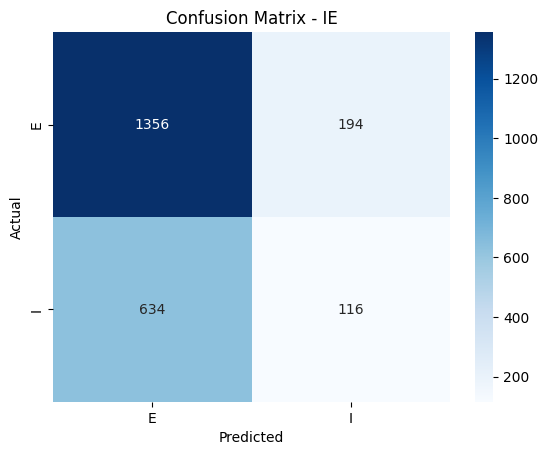


=== Confusion Matrix for NS ===


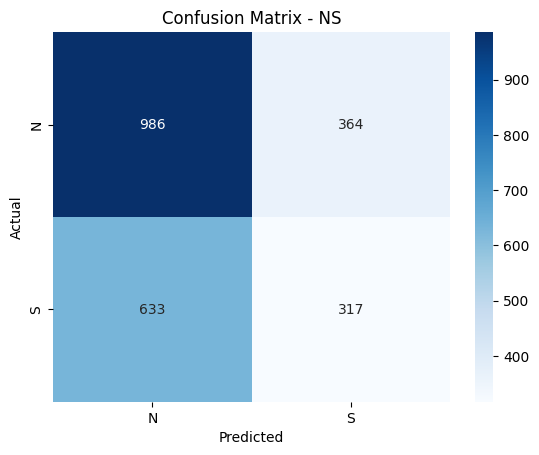


=== Confusion Matrix for TF ===


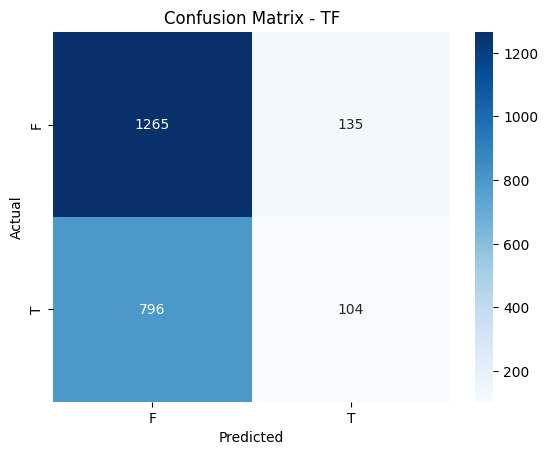


=== Confusion Matrix for JP ===


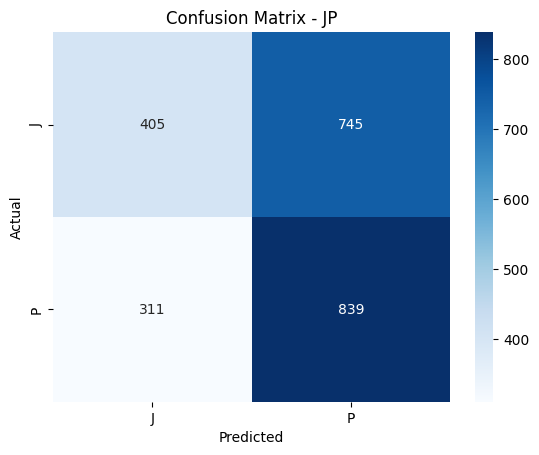

In [47]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, label_name):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(y_true),
                yticklabels=np.unique(y_true))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {label_name}')
    plt.show()

# Pastikan label ada di data uji
if 'IE' in df_test.columns:
    print("\n=== Confusion Matrix for IE ===")
    plot_confusion_matrix(df_test['IE'], y_test_pred_IE, 'IE')

if 'NS' in df_test.columns:
    print("\n=== Confusion Matrix for NS ===")
    plot_confusion_matrix(df_test['NS'], y_test_pred_NS, 'NS')

if 'TF' in df_test.columns:
    print("\n=== Confusion Matrix for TF ===")
    plot_confusion_matrix(df_test['TF'], y_test_pred_TF, 'TF')

if 'JP' in df_test.columns:
    print("\n=== Confusion Matrix for JP ===")
    plot_confusion_matrix(df_test['JP'], y_test_pred_JP, 'JP')


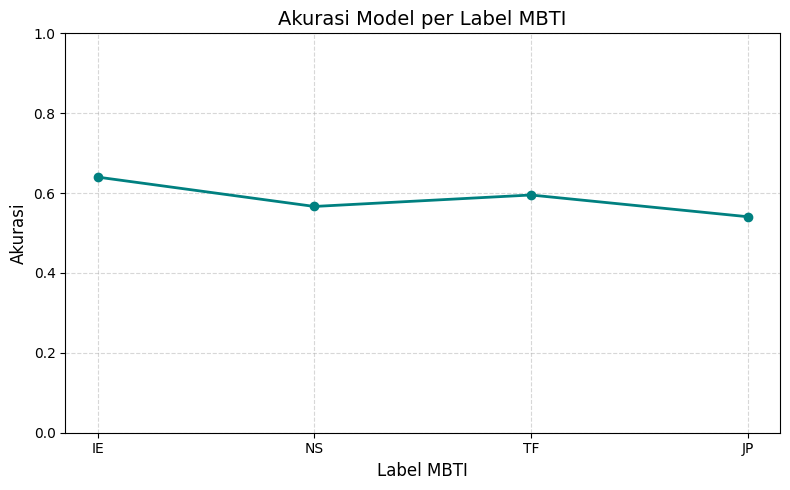

In [48]:
# Simpan semua akurasi ke dictionary otomatis
akurasi_dict = {}

if 'IE' in df_test.columns:
    akurasi_dict['IE'] = accuracy_score(df_test['IE'], y_test_pred_IE)

if 'NS' in df_test.columns:
    akurasi_dict['NS'] = accuracy_score(df_test['NS'], y_test_pred_NS)

if 'TF' in df_test.columns:
    akurasi_dict['TF'] = accuracy_score(df_test['TF'], y_test_pred_TF)

if 'JP' in df_test.columns:
    akurasi_dict['JP'] = accuracy_score(df_test['JP'], y_test_pred_JP)

# Buat list untuk plotting
labels = list(akurasi_dict.keys())
accuracies = list(akurasi_dict.values())

# Plot line chart
plt.figure(figsize=(8, 5))
plt.plot(labels, accuracies, marker='o', linestyle='-', color='teal', linewidth=2)

plt.title('Akurasi Model per Label MBTI', fontsize=14)
plt.xlabel('Label MBTI', fontsize=12)
plt.ylabel('Akurasi', fontsize=12)
plt.ylim(0, 1.0)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


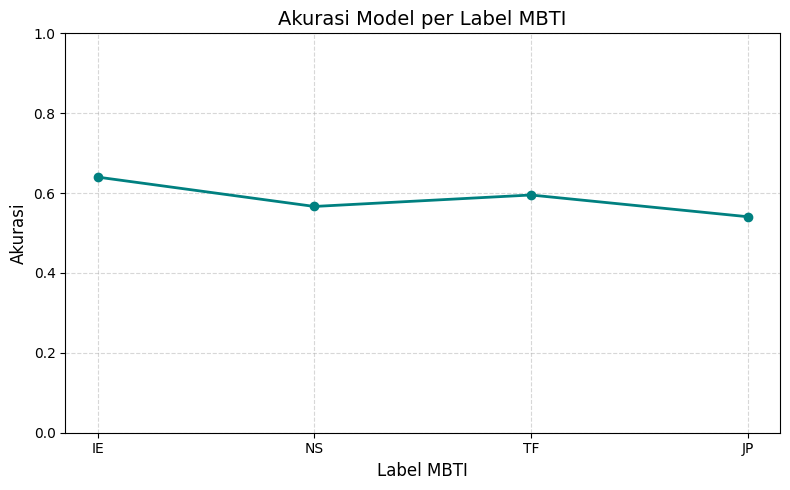

In [49]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Simpan semua akurasi ke dictionary otomatis
akurasi_dict = {}

if 'IE' in df_test.columns:
    akurasi_dict['IE'] = accuracy_score(df_test['IE'], y_test_pred_IE)

if 'NS' in df_test.columns:
    akurasi_dict['NS'] = accuracy_score(df_test['NS'], y_test_pred_NS)

if 'TF' in df_test.columns:
    akurasi_dict['TF'] = accuracy_score(df_test['TF'], y_test_pred_TF)

if 'JP' in df_test.columns:
    akurasi_dict['JP'] = accuracy_score(df_test['JP'], y_test_pred_JP)

# Buat list untuk plotting
labels = list(akurasi_dict.keys())
accuracies = list(akurasi_dict.values())

# Plot line chart
plt.figure(figsize=(8, 5))
plt.plot(labels, accuracies, marker='o', linestyle='-', color='teal', linewidth=2)

plt.title('Akurasi Model per Label MBTI', fontsize=14)
plt.xlabel('Label MBTI', fontsize=12)
plt.ylabel('Akurasi', fontsize=12)
plt.ylim(0, 1.0)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


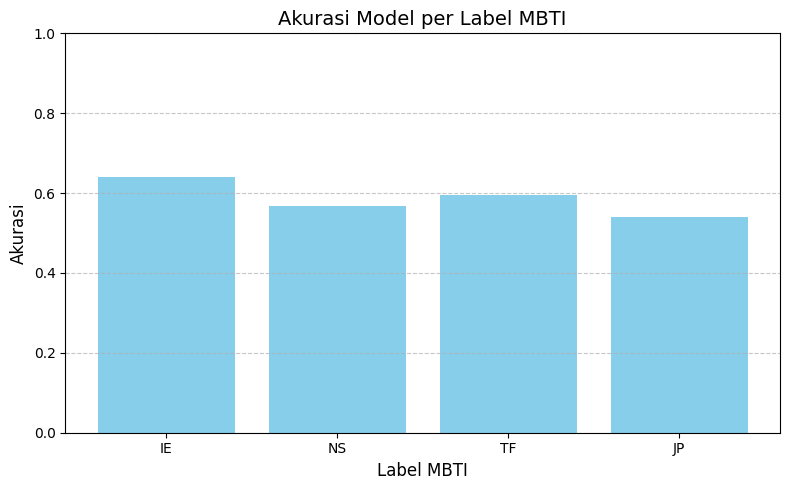

In [50]:
plt.figure(figsize=(8, 5))
plt.bar(labels, accuracies, color='skyblue')
plt.title('Akurasi Model per Label MBTI', fontsize=14)
plt.xlabel('Label MBTI', fontsize=12)
plt.ylabel('Akurasi', fontsize=12)
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


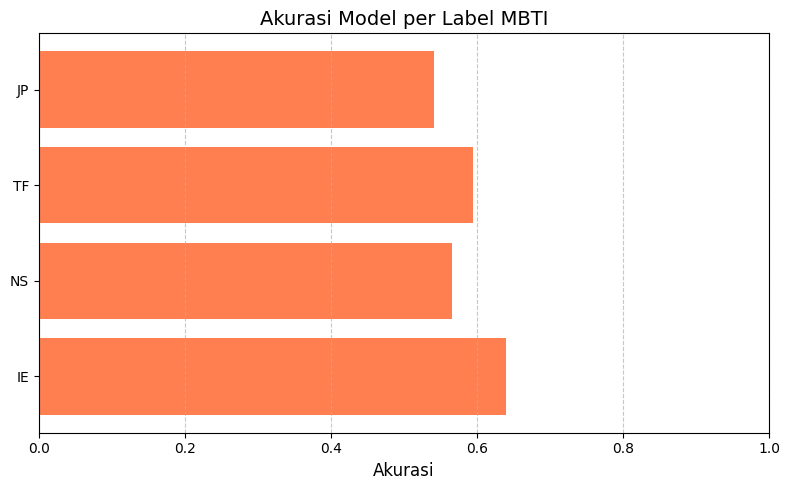

In [51]:
plt.figure(figsize=(8, 5))
plt.barh(labels, accuracies, color='coral')
plt.title('Akurasi Model per Label MBTI', fontsize=14)
plt.xlabel('Akurasi', fontsize=12)
plt.xlim(0, 1.0)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [52]:
# Ambil individu terbaik hasil GA untuk label IE
#best_individu_IE = best_chromosome_history[np.argmax(best_fitness_history)]
#selected_features_IE = [i for i, bit in enumerate(best_individu_IE[:-1]) if bit == 1]
#C_best_IE = best_individu_IE[-1]

# Subset fitur dari TF-IDF data latih sesuai fitur terpilih
#X_train_final_IE = X_train[:, selected_features_IE]

# Latih model
#clf_IE_final = SVC(C=C_best_IE, kernel='rbf', gamma='scale')
#clf_IE_final.fit(X_train_final_IE, y_train_IE)

# Evaluasi di data latih
#y_train_pred_IE = clf_IE_final.predict(X_train_final_IE)
#acc_train_IE = accuracy_score(y_train_IE, y_train_pred_IE)


In [53]:
# === [1] Prediksi label IE di data uji ===
#y_test_pred_IE = clf_IE_final.predict(X_test_final_IE)

# === [2] Evaluasi akurasi atau metrik lainnya ===
#from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Pastikan label IE dari data uji tersedia
#y_test_IE = df_test['IE'].values  # ganti sesuai kolom label di file test

# Hitung akurasi
#acc_test_IE = accuracy_score(y_test_IE, y_test_pred_IE)
#print(f"Akurasi data uji (testing) IE: {acc_test_IE:.4f}")

# Tambahan evaluasi
#print("\n=== Classification Report ===")
#print(classification_report(y_test_IE, y_test_pred_IE))



In [54]:
# Ambil individu terbaik hasil GA untuk label NS
#best_individu_NS = best_chromosome_history[np.argmax(best_fitness_history)]
#selected_features_NS = [i for i, bit in enumerate(best_individu_NS[:-1]) if bit == 1]
#C_best_NS = best_individu_NS[-1]

# Subset fitur dari data latih
#X_train_final_NS = X_train[:, selected_features_NS]

#clf_NS_final = SVC(C=C_best_NS, kernel='rbf', gamma='scale')
#clf_NS_final.fit(X_train_final_NS, y_train_NS)

# Evaluasi di data latih
#y_train_pred_NS = clf_NS_final.predict(X_train_final_NS)
#acc_train_NS = accuracy_score(y_train_NS, y_train_pred_NS)


In [55]:
# === [1] Prediksi label NS di data uji ===
#y_test_pred_NS = clf_NS_final.predict(X_test_final_NS)

# === [2] Evaluasi akurasi atau metrik lainnya ===
#from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Pastikan label NS dari data uji tersedia
#y_test_NS = df_test['NS'].values  # ganti sesuai kolom label di file test

# Hitung akurasi
#acc_test_NS = accuracy_score(y_test_NS, y_test_pred_NS)
#print(f"Akurasi data uji (testing) NS: {acc_test_NS:.4f}")

# Tambahan evaluasi
#print("\n=== Classification Report ===")
#print(classification_report(y_test_NS, y_test_pred_NS))


In [56]:
# Ambil individu terbaik hasil GA untuk label TF
#best_individu_TF = best_chromosome_history[np.argmax(best_fitness_history)]
#selected_features_TF = [i for i, bit in enumerate(best_individu_TF[:-1]) if bit == 1]
#C_best_TF = best_individu_TF[-1]

# Subset fitur dari data latih
#X_train_final_TF = X_train[:, selected_features_TF]

#clf_TF_final = SVC(C=C_best_TF, kernel='rbf', gamma='scale')
#clf_TF_final.fit(X_train_final_TF, y_train_TF)

# Evaluasi di data latih
#y_train_pred_TF = clf_TF_final.predict(X_train_final_TF)
#acc_train_TF = accuracy_score(y_train_TF, y_train_pred_TF)


In [57]:
# === [1] Prediksi label TF di data uji ===
#y_test_pred_TF = clf_TF_final.predict(X_test_final_TF)

# === [2] Evaluasi akurasi atau metrik lainnya ===
#from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Pastikan label TF dari data uji tersedia
#y_test_TF = df_test['TF'].values  # ganti sesuai kolom label di file test

# Hitung akurasi
#acc_test_TF = accuracy_score(y_test_TF, y_test_pred_TF)
#print(f"Akurasi data uji (testing) TF: {acc_test_TF:.4f}")

# Tambahan evaluasi
#print("\n=== Classification Report ===")
#print(classification_report(y_test_TF, y_test_pred_TF))



In [58]:
# Ambil individu terbaik hasil GA untuk label JP
#best_individu_JP = best_chromosome_history[np.argmax(best_fitness_history)]
#selected_features_JP = [i for i, bit in enumerate(best_individu_JP[:-1]) if bit == 1]
#C_best_JP = best_individu_JP[-1]

# Subset fitur dari data latih
#X_train_final_JP = X_train[:, selected_features_JP]

#clf_JP_final = SVC(C=C_best_JP, kernel='rbf', gamma='scale')
#clf_JP_final.fit(X_train_final_JP, y_train_JP)

# Evaluasi di data latih
#y_train_pred_JP = clf_JP_final.predict(X_train_final_JP)
#acc_train_JP = accuracy_score(y_train_JP, y_train_pred_JP)


In [59]:
# === [1] Prediksi label JP di data uji ===
#y_test_pred_JP = clf_JP_final.predict(X_test_final_JP)

# === [2] Evaluasi akurasi atau metrik lainnya ===
#from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Pastikan label JP dari data uji tersedia
#y_test_JP = df_test['JP'].values  # ganti sesuai kolom label di file test

# Hitung akurasi
#acc_test_JP = accuracy_score(y_test_JP, y_test_pred_JP)
#print(f"Akurasi data uji (testing) JP: {acc_test_JP:.4f}")

# Tambahan evaluasi
#print("\n=== Classification Report ===")
#print(classification_report(y_test_JP, y_test_pred_JP))
